# LOGOTS
Transformation layer notebook

In [3]:
import pandas as pd
import numpy as np
from scipy.fftpack import fft, fftfreq
import time
import ast
from scipy import signal
import matplotlib as plt
from scipy.signal import spectrogram

## 1. Upload CSVs

In [5]:
stg_audio_data = pd.read_csv("stg_audio_data.csv")

In [6]:
# Convert `audio_samples` column from string to list
stg_audio_data['audio_samples'] = stg_audio_data['audio_samples'].apply(ast.literal_eval)

In [7]:
stg_audio_data.head(10)

,frame_id,timestamp,audio_samples
0,0,2024-11-20 15:25:02.250119,"[-481, 0, 0, -240, -240, -722, -722, -722, -72..."
1,1,2024-11-20 15:25:02.289591,"[-843, -843, 240, 240, 361, 361, 361, 361, -24..."
2,2,2024-11-20 15:25:02.316173,"[-602, -602, -120, -120, -722, -722, -602, -60..."
3,3,2024-11-20 15:25:02.379662,"[722, 722, -361, -361, -361, -361, -481, -481,..."
4,4,2024-11-20 15:25:02.578421,"[1325, 1325, 1325, 1325, 963, 963, 963, 963, 1..."
5,5,2024-11-20 15:25:02.776925,"[-722, -722, -602, -602, -481, -481, 0, 0, 481..."
6,6,2024-11-20 15:25:02.975164,"[1807, 1807, 1807, 1807, 1686, 1686, 1566, 156..."
7,7,2024-11-20 15:25:03.173119,"[-120, -120, 0, 0, 1084, 1084, 1807, 1807, 240..."
8,8,2024-11-20 15:25:03.495915,"[-13612, -13612, -6866, -6866, 602, 602, -6746..."
9,9,2024-11-20 15:25:03.694949,"[-8914, -8914, 1084, 1084, -3493, -3493, -2047..."


## 2. Define Transformation Functions

In [1764]:
def compute_fft(samples, sampling_rate=8000):
    """
    Computes the FFT for the given audio samples.

    Parameters:
        samples (list or np.array): Audio samples.
        sampling_rate (int): Sampling rate of the audio.

    Returns:
        dict: A dictionary with 'freqs' and 'magnitudes'.
    """
    samples = np.array(samples)
    n = len(samples)
    freqs = np.fft.rfftfreq(n, d=1/sampling_rate)
    fft_values = np.abs(np.fft.rfft(samples))
    return {"freqs": freqs, "magnitudes": fft_values}

def classify_voice_or_noise(freqs, magnitudes, voice_freq_range=(500, 3500), energy_threshold=15000000):
    """
    Classifies whether the given frequencies and magnitudes represent a voice or noise.

    Parameters:
        freqs (list or np.array): Frequencies from the FFT.
        magnitudes (list or np.array): Corresponding magnitudes for the frequencies.
        voice_freq_range (tuple): The frequency range considered as 'voice'. Default is (85, 255) Hz.
        energy_threshold (float): The minimum energy (sum of magnitudes in the range) to classify as voice.

    Returns:
        str: 'Voice' if the input is classified as voice, 'Noise' otherwise.
    """
    # Convert to numpy arrays for efficient computation
    freqs = np.array(freqs)
    magnitudes = np.array(magnitudes)

    # Find indices within the voice frequency range
    voice_indices = (freqs >= voice_freq_range[0]) & (freqs <= voice_freq_range[1])

    # Calculate total energy in the voice frequency range
    voice_energy = np.sum(magnitudes[voice_indices])

    # Classify based on energy threshold
    if voice_energy > energy_threshold:
        return "Voice"
    else:
        return "Noise"
        

def detect_cat_voice(classification, freqs, magnitudes, freq_range=(400, 700), harmonic_range=(200, 1000), harmonic_threshold=15):
    """
    Determines if the detected voice is a cat's voice based on spectral peaks and harmonic energy.

    Parameters:
        classification (str): The classification ('Voice' or 'Noise').
        freqs (list or np.array): Frequencies from the FFT result.
        magnitudes (list or np.array): Magnitudes corresponding to the frequencies.
        freq_range (tuple): Frequency range for a cat's voice.
        harmonic_range (tuple): Frequency range for detecting harmonics.
        harmonic_threshold (float): Ratio of harmonic energy to primary peak magnitude to classify as human.

    Returns:
        int: 1 if the detected voice is a cat's voice, 0 otherwise.
    """
    if classification != "Voice":
        return 0

    # Convert to numpy arrays for efficient computation
    freqs = np.array(freqs)
    magnitudes = np.array(magnitudes)

    # Select frequencies and magnitudes within the primary range (cat voice range)
    primary_mask = (freqs >= freq_range[0]) & (freqs <= freq_range[1])
    primary_freqs = freqs[primary_mask]
    primary_magnitudes = magnitudes[primary_mask]

    if len(primary_freqs) == 0 or len(primary_magnitudes) == 0:
        return 0  # No energy in the cat's voice range

    # Find the primary peak (highest magnitude in the primary range)
    primary_peak_magnitude = primary_magnitudes.max()

    # Check for harmonics in the harmonic range
    harmonic_mask = (freqs >= harmonic_range[0]) & (freqs <= harmonic_range[1])
    harmonic_magnitudes = magnitudes[harmonic_mask]

    # Calculate total harmonic energy
    harmonic_energy = np.sum(harmonic_magnitudes)

    # Classify as a cat's voice if harmonic energy is low relative to the primary peak
    if harmonic_energy / primary_peak_magnitude < harmonic_threshold:
        return 1  # Cat's voice detected

    return 0  # Not a cat's voice

def detect_human_voice(classification, freqs, magnitudes, freq_range=(150, 600), harmonic_range=(2000, 4000), harmonic_threshold=15):
    """
    Determines if the detected voice is a human's voice based on normalized average of squared magnitudes
    and harmonic energy analysis.

    Parameters:
        classification (str): The classification ('Voice' or 'Noise').
        freqs (list or np.array): Frequencies from the FFT result.
        magnitudes (list or np.array): Magnitudes corresponding to the frequencies.
        freq_range (tuple): Frequency range for a human's voice.
        harmonic_range (tuple): Frequency range to detect harmonic energy for human voices.
        harmonic_threshold (float): Threshold for detecting significant harmonic energy.

    Returns:
        int: 1 if the detected voice is a human's voice, 0 otherwise.
    """
    if classification != "Voice":
        return 0

    # Convert to numpy arrays for efficient computation
    freqs = np.array(freqs)
    magnitudes = np.array(magnitudes)

    # Select frequencies and magnitudes within the primary human voice range
    primary_mask = (freqs >= freq_range[0]) & (freqs <= freq_range[1])
    primary_magnitudes = magnitudes[primary_mask]

    if len(primary_magnitudes) == 0:
        return 0

    # Calculate normalized average squared magnitude within the primary range
    primary_energy = np.mean(primary_magnitudes**2) / np.max(magnitudes**2)

    # Select frequencies and magnitudes within the harmonic range
    harmonic_mask = (freqs >= harmonic_range[0]) & (freqs <= harmonic_range[1])
    harmonic_magnitudes = magnitudes[harmonic_mask]

    if len(harmonic_magnitudes) == 0:
        return 0

    # Calculate total harmonic energy
    harmonic_energy = np.sum(harmonic_magnitudes)

    # Detect human voice if primary energy and harmonic energy exceed thresholds
    if primary_energy > 0.1 and harmonic_energy > harmonic_threshold:
        return 1

    return 0

def calculate_meow_loudness(is_cat_voice, magnitudes):
    """
    Buckets the loudness of a meow into 'low', 'medium', or 'high' if is_cat_voice is True.

    Parameters:
        is_cat_voice (int): 1 if it's a cat's voice, 0 otherwise.
        magnitudes (list): Magnitudes corresponding to the FFT result.

    Returns:
        str: 'low', 'medium', or 'high' if is_cat_voice is True; 'none' otherwise.
    """
    if is_cat_voice != 1:
        return "none"  # Not a cat's voice
    
    # Calculate the average loudness from magnitudes
    avg_loudness = np.mean(magnitudes)

    # Define thresholds for loudness buckets
    if avg_loudness < 40000:  # Threshold for low loudness
        return "low"
    elif 40000 <= avg_loudness <= 60000:  # Threshold for medium loudness
        return "medium"
    else:  # Threshold for high loudness
        return "high"

def calculate_dominant_frequency(freqs, magnitudes):
    """
    Calculates the dominant frequency from the FFT results.

    Parameters:
        freqs (list or array): List or array of frequencies from the FFT result.
        magnitudes (list or array): Corresponding magnitudes for the frequencies.

    Returns:
        float: The frequency with the highest magnitude.
    """
    # Check if freqs or magnitudes are empty
    if freqs.size == 0 or magnitudes.size == 0:
        return 0  # Return 0 if no frequencies or magnitudes are present

    # Find the index of the maximum magnitude
    max_index = np.argmax(magnitudes)

    # Return the frequency corresponding to the max magnitude
    return freqs[max_index]

In [1766]:
# Timing function
def measure_time(func, *args, **kwargs):
    """
    Measures the execution time of a function.

    Parameters:
        func (callable): Function to be executed.
        *args: Positional arguments for the function.
        **kwargs: Keyword arguments for the function.

    Returns:
        tuple: (result, execution_time_in_seconds)
    """
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    return result, end_time - start_time

## 3. Execute functions

In [1769]:
new_dataframe = stg_audio_data[['frame_id', 'timestamp']]

In [1771]:
# 1. Compute FFT and time it
new_dataframe["fft_result"], fft_time = measure_time(
    lambda: stg_audio_data["audio_samples"].apply(compute_fft)
)
print(f"FFT computation time: {fft_time:.6f} seconds")

# 2. Classify voice or noise and time it
new_dataframe["classification"], classification_time = measure_time(
    lambda: new_dataframe["fft_result"].apply(
        lambda x: classify_voice_or_noise(x["freqs"], x["magnitudes"])
    )
)
print(f"Voice/Noise classification time: {classification_time:.6f} seconds")

# 3. Detect cat voice and time it
new_dataframe["is_cat_voice"], cat_voice_time = measure_time(
    lambda: new_dataframe.apply(
        lambda row: detect_cat_voice(
            row["classification"], row["fft_result"]["freqs"], row["fft_result"]["magnitudes"]
        ),
        axis=1
    )
)
print(f"Cat voice detection time: {cat_voice_time:.6f} seconds")

# 4. Detect human voice and time it
new_dataframe["is_human_voice"], human_voice_time = measure_time(
    lambda: new_dataframe.apply(
        lambda row: detect_human_voice(
            row["classification"], row["fft_result"]["freqs"], row["fft_result"]["magnitudes"]
        ),
        axis=1
    )
)
print(f"Human voice detection time: {human_voice_time:.6f} seconds")

# 5. Calculate meow loudness and time it
new_dataframe["meow_loudness"], meow_loudness_time = measure_time(
    lambda: new_dataframe.apply(
        lambda row: calculate_meow_loudness(
            row["is_cat_voice"], row["fft_result"]["magnitudes"]
        ),
        axis=1
    )
)
print(f"Meow loudness calculation time: {meow_loudness_time:.6f} seconds")

# 6. Calculate dominant frequency and time it
new_dataframe["dominant_frequency"], dominant_frequency_time = measure_time(
    lambda: new_dataframe["fft_result"].apply(
        lambda x: calculate_dominant_frequency(x["freqs"], x["magnitudes"])
    )
)
print(f"Dominant frequency calculation time: {dominant_frequency_time:.6f} seconds")

FFT computation time: 0.007166 seconds
Voice/Noise classification time: 0.000851 seconds
Cat voice detection time: 0.001019 seconds
Human voice detection time: 0.000994 seconds
Meow loudness calculation time: 0.000321 seconds
Dominant frequency calculation time: 0.000129 seconds


In [1773]:
new_dataframe

,frame_id,timestamp,fft_result,classification,is_cat_voice,is_human_voice,meow_loudness,dominant_frequency
0,0,2024-11-20 15:25:02.250119,"{'freqs': [0.0, 4.761904761904762, 9.523809523...",Noise,0,0,none,33.333333
1,1,2024-11-20 15:25:02.289591,"{'freqs': [0.0, 4.761904761904762, 9.523809523...",Noise,0,0,none,152.380952
2,2,2024-11-20 15:25:02.316173,"{'freqs': [0.0, 4.761904761904762, 9.523809523...",Noise,0,0,none,19.047619
3,3,2024-11-20 15:25:02.379662,"{'freqs': [0.0, 4.761904761904762, 9.523809523...",Noise,0,0,none,52.380952
4,4,2024-11-20 15:25:02.578421,"{'freqs': [0.0, 4.761904761904762, 9.523809523...",Noise,0,0,none,52.380952
5,5,2024-11-20 15:25:02.776925,"{'freqs': [0.0, 4.761904761904762, 9.523809523...",Noise,0,0,none,52.380952
6,6,2024-11-20 15:25:02.975164,"{'freqs': [0.0, 4.761904761904762, 9.523809523...",Noise,0,0,none,52.380952
7,7,2024-11-20 15:25:03.173119,"{'freqs': [0.0, 4.761904761904762, 9.523809523...",Voice,1,0,high,666.666667
8,8,2024-11-20 15:25:03.495915,"{'freqs': [0.0, 4.761904761904762, 9.523809523...",Voice,1,0,high,595.238095
9,9,2024-11-20 15:25:03.694949,"{'freqs': [0.0, 4.761904761904762, 9.523809523...",Voice,1,0,high,1195.238095


## 4. Visualize Data

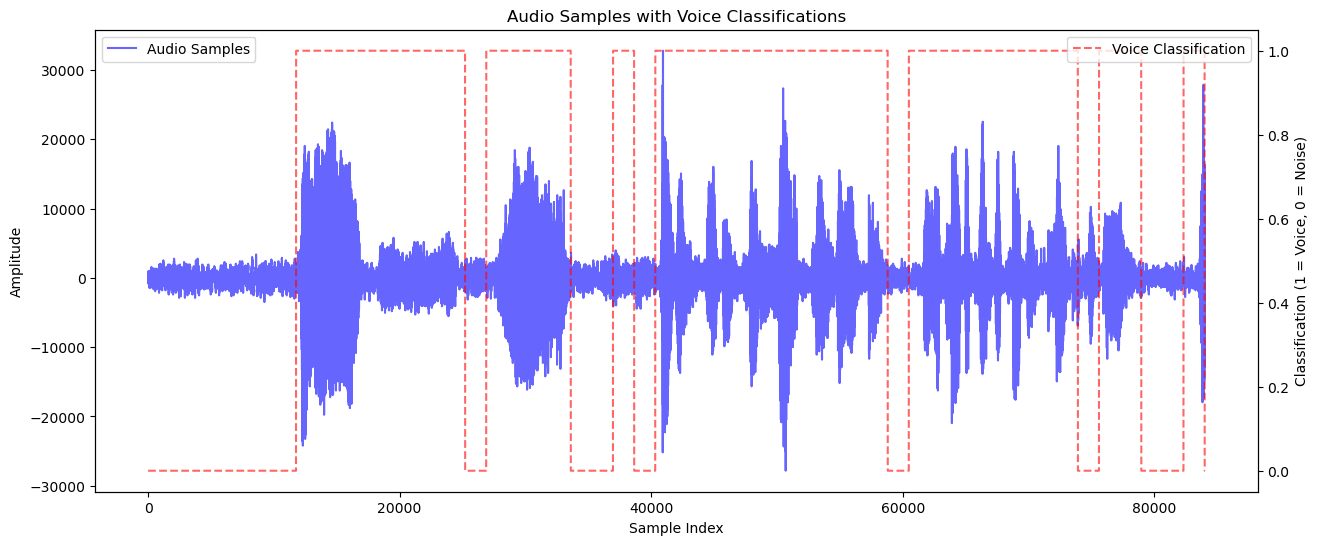

In [1776]:
def plot_audio_with_classifications(stg_audio_data, new_dataframe):
    """
    Plots the concatenated audio samples with voice classifications on a secondary y-axis.

    Parameters:
        stg_audio_data (pd.DataFrame): DataFrame containing `frame_id` and `audio_samples`.
        new_dataframe (pd.DataFrame): DataFrame containing `frame_id` and `classification`.
    """
    # Concatenate all audio samples into a single array
    concatenated_samples = []
    for samples in stg_audio_data["audio_samples"]:
        concatenated_samples.extend(samples)

    # Prepare the classifications to align with the concatenated audio
    classifications = []
    for frame_id in stg_audio_data["frame_id"]:
        # Get classification for the frame from new_dataframe
        classification = new_dataframe.loc[
            new_dataframe["frame_id"] == frame_id, "classification"
        ].values
        if len(classification) > 0:
            classifications.append(1 if classification[0] == "Voice" else 0)
        else:
            classifications.append(0)  # Default to 0 if no classification

    # Expand classifications to match the length of the audio samples for each frame
    samples_per_frame = [len(samples) for samples in stg_audio_data["audio_samples"]]
    expanded_classifications = []
    for i, samples_count in enumerate(samples_per_frame):
        expanded_classifications.extend([classifications[i]] * samples_count)

    # Plot the audio samples
    fig, ax1 = plt.subplots(figsize=(15, 6))
    ax1.plot(concatenated_samples, label="Audio Samples", color="blue", alpha=0.6)
    ax1.set_xlabel("Sample Index")
    ax1.set_ylabel("Amplitude")
    ax1.legend(loc="upper left")

    # Plot classifications on a secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(expanded_classifications, label="Voice Classification", color="red", alpha=0.6, linestyle="--")
    ax2.set_ylabel("Classification (1 = Voice, 0 = Noise)")
    ax2.legend(loc="upper right")

    plt.title("Audio Samples with Voice Classifications")
    plt.show()

# Usage example:
plot_audio_with_classifications(stg_audio_data, new_dataframe)

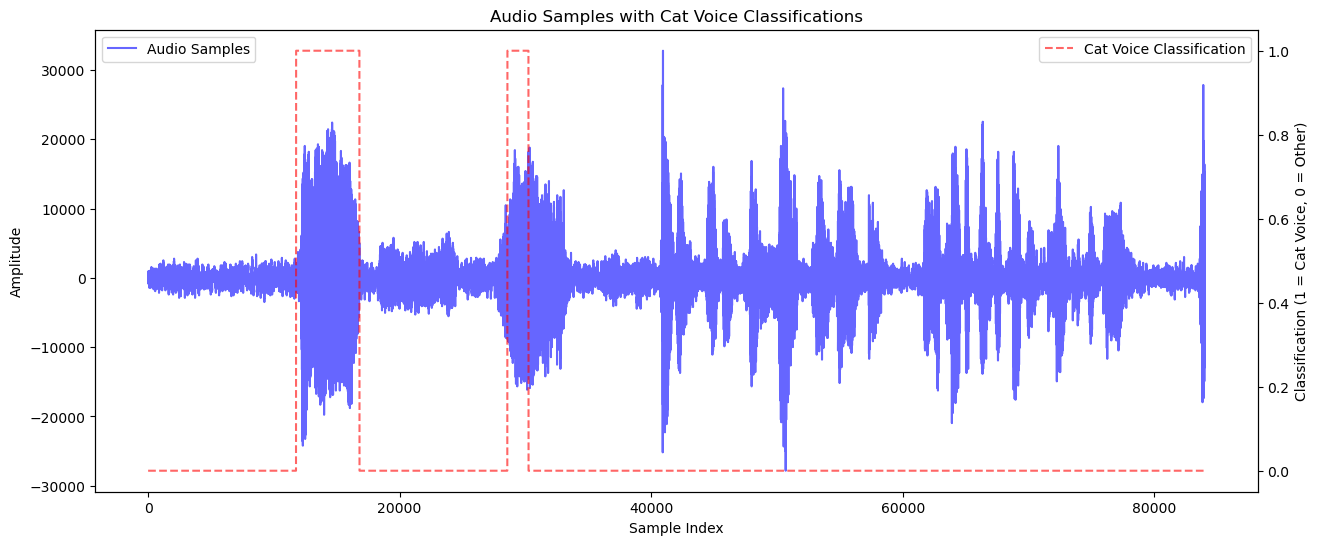

In [1778]:
def plot_audio_with_cat_voice(stg_audio_data, new_dataframe):
    """
    Plots the concatenated audio samples with cat voice classifications on a secondary y-axis.

    Parameters:
        stg_audio_data (pd.DataFrame): DataFrame containing `frame_id` and `audio_samples`.
        new_dataframe (pd.DataFrame): DataFrame containing `frame_id` and `is_cat_voice`.
    """
    # Concatenate all audio samples into a single array
    concatenated_samples = []
    for samples in stg_audio_data["audio_samples"]:
        concatenated_samples.extend(samples)

    # Prepare the is_cat_voice values to align with the concatenated audio
    cat_voice_flags = []
    for frame_id in stg_audio_data["frame_id"]:
        # Get is_cat_voice for the frame from new_dataframe
        is_cat_voice = new_dataframe.loc[
            new_dataframe["frame_id"] == frame_id, "is_cat_voice"
        ].values
        if len(is_cat_voice) > 0:
            cat_voice_flags.append(is_cat_voice[0])
        else:
            cat_voice_flags.append(0)  # Default to 0 if no classification

    # Expand cat voice flags to match the length of the audio samples for each frame
    samples_per_frame = [len(samples) for samples in stg_audio_data["audio_samples"]]
    expanded_cat_voice_flags = []
    for i, samples_count in enumerate(samples_per_frame):
        expanded_cat_voice_flags.extend([cat_voice_flags[i]] * samples_count)

    # Plot the audio samples
    fig, ax1 = plt.subplots(figsize=(15, 6))
    ax1.plot(concatenated_samples, label="Audio Samples", color="blue", alpha=0.6)
    ax1.set_xlabel("Sample Index")
    ax1.set_ylabel("Amplitude")
    ax1.legend(loc="upper left")

    # Plot cat voice classifications on a secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(expanded_cat_voice_flags, label="Cat Voice Classification", color="red", alpha=0.6, linestyle="--")
    ax2.set_ylabel("Classification (1 = Cat Voice, 0 = Other)")
    ax2.legend(loc="upper right")

    plt.title("Audio Samples with Cat Voice Classifications")
    plt.show()

# Usage example:
plot_audio_with_cat_voice(stg_audio_data, new_dataframe)

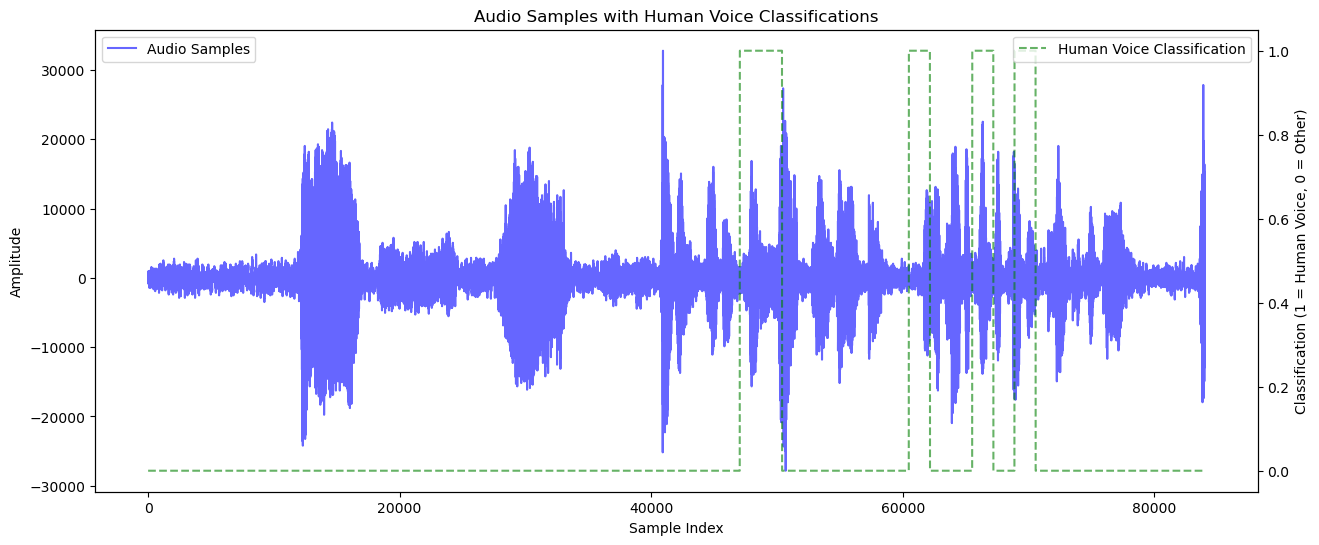

In [1780]:
def plot_audio_with_human_voice(stg_audio_data, new_dataframe):
    """
    Plots the concatenated audio samples with human voice classifications on a secondary y-axis.

    Parameters:
        stg_audio_data (pd.DataFrame): DataFrame containing `frame_id` and `audio_samples`.
        new_dataframe (pd.DataFrame): DataFrame containing `frame_id` and `is_human_voice`.
    """
    # Concatenate all audio samples into a single array
    concatenated_samples = []
    for samples in stg_audio_data["audio_samples"]:
        concatenated_samples.extend(samples)

    # Prepare the is_human_voice values to align with the concatenated audio
    human_voice_flags = []
    for frame_id in stg_audio_data["frame_id"]:
        # Get is_human_voice for the frame from new_dataframe
        is_human_voice = new_dataframe.loc[
            new_dataframe["frame_id"] == frame_id, "is_human_voice"
        ].values
        if len(is_human_voice) > 0:
            human_voice_flags.append(is_human_voice[0])
        else:
            human_voice_flags.append(0)  # Default to 0 if no classification

    # Expand human voice flags to match the length of the audio samples for each frame
    samples_per_frame = [len(samples) for samples in stg_audio_data["audio_samples"]]
    expanded_human_voice_flags = []
    for i, samples_count in enumerate(samples_per_frame):
        expanded_human_voice_flags.extend([human_voice_flags[i]] * samples_count)

    # Plot the audio samples
    fig, ax1 = plt.subplots(figsize=(15, 6))
    ax1.plot(concatenated_samples, label="Audio Samples", color="blue", alpha=0.6)
    ax1.set_xlabel("Sample Index")
    ax1.set_ylabel("Amplitude")
    ax1.legend(loc="upper left")

    # Plot human voice classifications on a secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(expanded_human_voice_flags, label="Human Voice Classification", color="green", alpha=0.6, linestyle="--")
    ax2.set_ylabel("Classification (1 = Human Voice, 0 = Other)")
    ax2.legend(loc="upper right")

    plt.title("Audio Samples with Human Voice Classifications")
    plt.show()

# Usage example:
plot_audio_with_human_voice(stg_audio_data, new_dataframe)

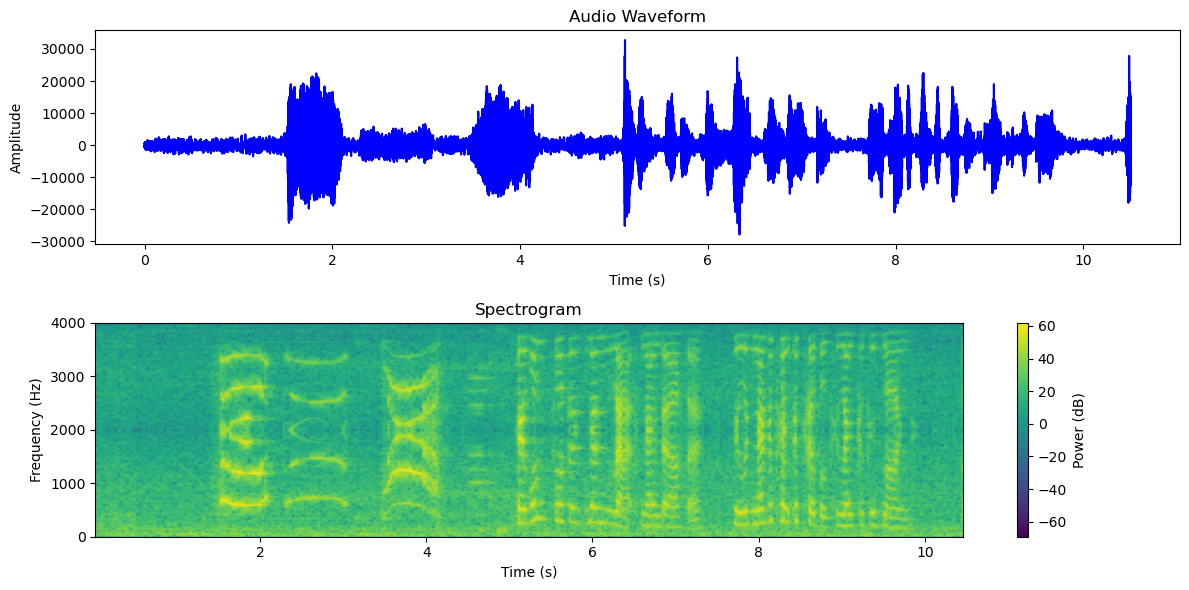

In [1782]:
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import numpy as np

# Function to plot waveform and spectrogram
def plot_waveform_and_spectrogram(stg_audio_data, sampling_rate=8000):
    """
    Plots the concatenated audio waveform and its spectrogram.

    Parameters:
        stg_audio_data (pd.DataFrame): DataFrame containing 'audio_samples' column as lists of audio samples.
        sampling_rate (int): Sampling rate of the audio in Hz. Default is 8000 Hz.
    """
    # Concatenate all audio samples from all frames
    concatenated_audio = np.concatenate(stg_audio_data["audio_samples"].values)

    # Create a time array for the waveform
    time = np.linspace(0, len(concatenated_audio) / sampling_rate, len(concatenated_audio))

    # Create the spectrogram
    f, t, Sxx = spectrogram(concatenated_audio, fs=sampling_rate)

    # Plot the waveform
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(time, concatenated_audio, color='blue')
    plt.title("Audio Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    # Plot the spectrogram
    plt.subplot(2, 1, 2)
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.colorbar(label="Power (dB)")
    plt.title("Spectrogram")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.tight_layout()
    plt.show()

# Assuming stg_audio_data is already loaded and contains the 'audio_samples' column
plot_waveform_and_spectrogram(stg_audio_data, sampling_rate=8000)

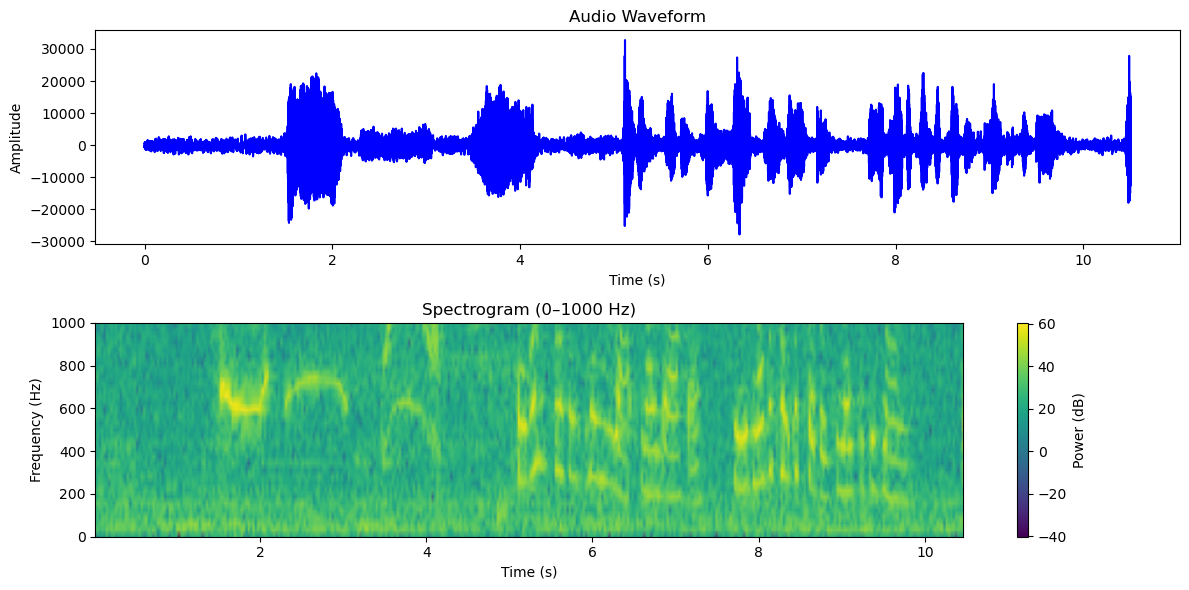

In [1685]:
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import numpy as np

# Function to plot waveform and zoomed-in spectrogram (0–1000 Hz)
def plot_waveform_and_zoomed_spectrogram(stg_audio_data, sampling_rate=8000):
    """
    Plots the concatenated audio waveform and its spectrogram, zoomed in to 0–1000 Hz.

    Parameters:
        stg_audio_data (pd.DataFrame): DataFrame containing 'audio_samples' column as lists of audio samples.
        sampling_rate (int): Sampling rate of the audio in Hz. Default is 8000 Hz.
    """
    # Concatenate all audio samples from all frames
    concatenated_audio = np.concatenate(stg_audio_data["audio_samples"].values)

    # Create a time array for the waveform
    time = np.linspace(0, len(concatenated_audio) / sampling_rate, len(concatenated_audio))

    # Create the spectrogram
    f, t, Sxx = spectrogram(concatenated_audio, fs=sampling_rate)

    # Filter for frequencies up to 1000 Hz
    freq_limit = 1000
    freq_mask = f <= freq_limit
    f_zoomed = f[freq_mask]
    Sxx_zoomed = Sxx[freq_mask, :]

    # Plot the waveform
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(time, concatenated_audio, color='blue')
    plt.title("Audio Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    # Plot the spectrogram zoomed in to 0–1000 Hz
    plt.subplot(2, 1, 2)
    plt.pcolormesh(t, f_zoomed, 10 * np.log10(Sxx_zoomed + 1e-10), shading='gouraud')
    plt.colorbar(label="Power (dB)")
    plt.title("Spectrogram (0–1000 Hz)")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.tight_layout()
    plt.show()

# Assuming stg_audio_data is already loaded and contains the 'audio_samples' column
plot_waveform_and_zoomed_spectrogram(stg_audio_data, sampling_rate=8000)

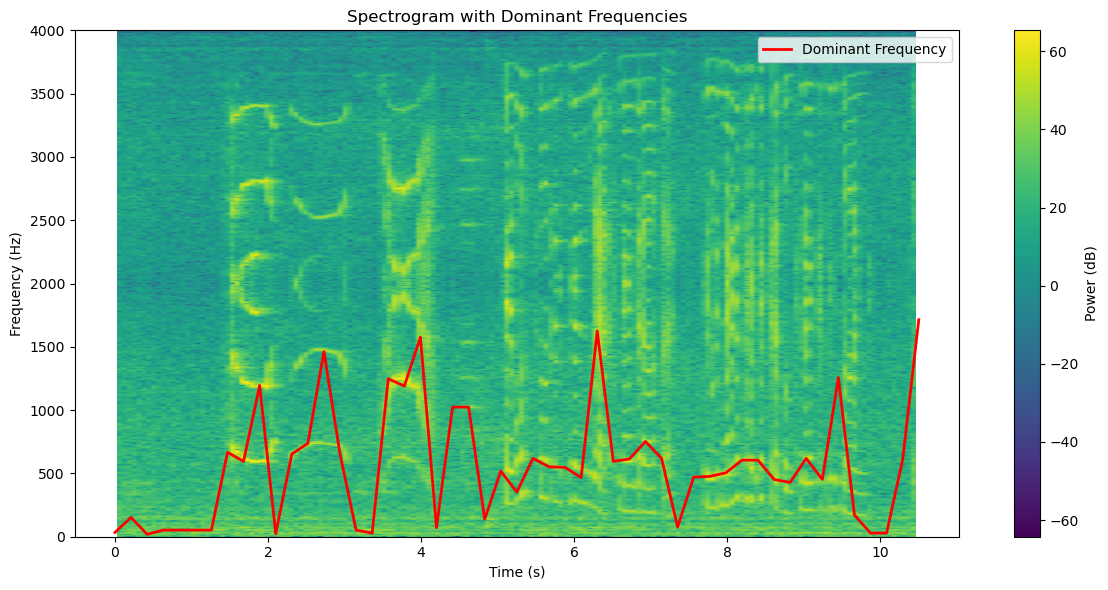

In [1687]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming new_dataframe and stg_audio_data are already defined
# Extract necessary data
audio_samples = np.concatenate(stg_audio_data["audio_samples"].values)
timestamps = np.cumsum([0] + [len(samples) for samples in stg_audio_data["audio_samples"].values[:-1]]) / 8000  # Convert to seconds
dominant_frequencies = new_dataframe["dominant_frequency"]

# Create the spectrogram
sampling_rate = 8000  # Assuming audio is sampled at 8 kHz
plt.figure(figsize=(12, 6))
plt.specgram(audio_samples, Fs=sampling_rate, NFFT=1024, noverlap=512, cmap="viridis")
plt.colorbar(label="Power (dB)")
plt.title("Spectrogram with Dominant Frequencies")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")

# Align dominant_frequencies with timestamps
dominant_timestamps = timestamps  # One timestamp per frame
plt.plot(dominant_timestamps, dominant_frequencies, color="red", label="Dominant Frequency", linewidth=2)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()